<div style="background-color: black; color: white; padding: 10px;text-align: center;">
  <strong>Date Published:</strong> November 24, 2025  <strong>~</strong>  <strong>Author:</strong> Adnan Alaref
</div>

# Build Your First Char-Level Text Generator

* Welcome to this clean and practical notebook!
* Here, we build a **character-level text generator** using a **simple RNN** and train it to **predict the next character** in a sequence.

---

## ✅ This notebook is designed to be:

### Beginner-Friendly
* Every step is explained clearly — **no prior NLP experience needed**.

### From Scratch
* We implement the core idea of next-character prediction **without relying on heavy frameworks**.

### Hands-On Learning
* You will see:
  - How sequences are prepared
  - How the model is trained
  - How the network learns to generate text **character by character**

---

## ✨ What you will learn

- How to **build a small vocabulary** from raw text.
- How to **Create custom Dataset** from scratch.
- How to **encode characters into integer sequences.**  
- How an **RNN processes text step-by-step.**  
- How to **train a simple next-character prediction model.**  
- How to **generate new text** using the trained network.  

---

## 📌 Why this notebook is useful

* Most resources jump directly to **LSTMs or Transformers**.  
* But understanding **character-level RNNs** gives you the **foundation for all sequence learning models**.

> If you’re learning **NLP** or **deep learning**, this notebook will give you a **simple, clear, and complete example** you can build on.

---

If you find this helpful, an **upvote would mean a lot 💙**  
Let’s get started! 🚀


# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 1: Import Library.</div>

In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
from typing import Tuple,Dict,Any,List,TypeVar,Type

import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 2: Prepare a Vocabulary.</div>

In [2]:
T = TypeVar("T", bound="Vocabulary")
class Vocabulary:
  def __init__(self, sentences) -> None:
    self.EOS_TOKEN = '<EOS>'
    self.UNK_TOKEN = '<UNK>'
    self.PAD_TOKEN = '<PAD>'

    self.chars = [self.PAD_TOKEN,self.EOS_TOKEN, self.UNK_TOKEN] + list(dict.fromkeys(' '.join(sentences)))
    self.char2idx = {c:i for i, c in enumerate(self.chars)}
    self.idx2char = {i:c for c, i in self.char2idx.items()}

    # Store indices for convenience
    self.PAD_IDX = self.char2idx[self.PAD_TOKEN]
    self.EOS_IDX = self.char2idx[self.EOS_TOKEN]
    self.UNK_IDX = self.char2idx[self.UNK_TOKEN]

  def __len__(self):
    return len(self.chars)

  def save(self, path:str)->None:
    torch.save({
     'chars': self.chars,
     'char2idx':self.char2idx,
     'EOS_TOKEN':self.EOS_TOKEN,
     'UNK_TOKEN':self.UNK_TOKEN,
     'PAD_TOKEN':self.PAD_TOKEN
    }, path)

  @classmethod
  def load(cls:Type[T], path:str)->T:
    data = torch.load(path)
    vocab = cls.__new__(cls)
    # Restore saved attributes
    vocab.chars = data['chars']
    vocab.char2idx = data['char2idx']
    vocab.EOS_TOKEN = data['EOS_TOKEN']
    vocab.UNK_TOKEN = data['UNK_TOKEN']
    vocab.PAD_TOKEN = data['PAD_TOKEN']
    vocab.idx2char = {idx:char for char,idx in vocab.char2idx.items()}
    return vocab

  def sentence_to_indices(self, sentence:List[str])-> List[int]:
    """Add EOS is **one token**
       Convert a sentence to list of indices
       Use .get() with fallback to UNK index
    """
    tokens = list(sentence) + [self.EOS_TOKEN]
    encoded = [self.char2idx.get(c, self.UNK_IDX) for c in tokens]
    return encoded

  def input_output_pairs(self, sentences:List[str], batch_size: int = 1)-> Tuple[torch.Tensor, torch.Tensor]:
    """
      Create (X, y) training pairs from sentences with batch support

      Args:
          sentences: List of input sentences
          batch_size: If 1, returns individual sequences without padding
                      If >1, returns batched sequences with padding

      Returns:
          X_tensor: Padded tensor if batch_size > 1, else list of tensors
          y_tensor: Target tensor
    """
    X, y = [], []

    # Convert all sentences to indices
    Sequences = [self.sentence_to_indices(sent) for sent in sentences]

    # Create input-output pairs
    for seq in Sequences:
      X.append(seq[:-1]) # X = all chars except last
      y.append(seq[1:])  # y = all chars except first

    if batch_size == 1:
      # Return individual sequences (no padding needed)
      X_tensor = [torch.tensor(xs, dtype=torch.long) for xs in X]
      y_tensor = [torch.tensor(ys, dtype=torch.long) for ys in y]

    else:
      # Pad sequences for batch processing
      X_tensor = pad_sequence(
        [torch.tensor(xs, dtype=torch.long) for xs in X],
        batch_first=True,
        padding_value=self.PAD_IDX
      )

      y_tensor = pad_sequence(
        [torch.tensor(ys, dtype=torch.long) for ys in y],
        batch_first=True,
        padding_value=self.PAD_IDX
      )
    return X_tensor, y_tensor

  def get_stats(self) -> dict:
    """Get vocabulary statistics"""
    return {
        'vocab_size': len(self),
        'num_special_tokens': 3,
        'special_tokens': {
            'PAD': self.PAD_TOKEN,
            'EOS': self.EOS_TOKEN,
            'UNK': self.UNK_TOKEN
        },
        'character_count': len(self.chars) - 3  # Excluding special tokens
    }

  def __repr__(self) -> str:
    stats = self.get_stats()
    return (f"Vocabulary(size={stats['vocab_size']}, "
            f"characters={stats['character_count']}, "
            f"special_tokens={stats['special_tokens']})")

In [3]:
test = ["Get Skilled in Machine Learning"]
v = Vocabulary(test)

In [4]:
xs ,ys = v.input_output_pairs(test)
xs, ys

([tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 10,  4, 11,  6,  9, 12,  6, 13, 14, 15,
          16,  9, 12,  4,  6, 17,  4, 14, 18, 12,  9, 12, 19])],
 [tensor([ 4,  5,  6,  7,  8,  9, 10, 10,  4, 11,  6,  9, 12,  6, 13, 14, 15, 16,
           9, 12,  4,  6, 17,  4, 14, 18, 12,  9, 12, 19,  1])])

##  <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 2.1: Prepare a small dataset.</div>

In [5]:
sentences = [
  "Adnan loves AI",
  "Machine learning fascinates him",
  "Exploring neural networks is exciting",
  "Sometimes, he wonders how robots learn",
  "Adnan enjoys discovering patterns in data",
  "AI can solve interesting problems and surprises him",
  "He dreams of creative applications of machine learning",
  "Adnan smiles when a model learns something new",
  "Understanding algorithms makes him curious about the future",
  "He loves watching AI explore and understand the world"
]
vocab = Vocabulary(sentences)

In [6]:
vocab

Vocabulary(size=36, characters=33, special_tokens={'PAD': '<PAD>', 'EOS': '<EOS>', 'UNK': '<UNK>'})

In [7]:
vocab.get_stats()

{'vocab_size': 36,
 'num_special_tokens': 3,
 'special_tokens': {'PAD': '<PAD>', 'EOS': '<EOS>', 'UNK': '<UNK>'},
 'character_count': 33}

In [8]:
vocab_size = len(vocab)
char2int = vocab.char2idx
int2char = vocab.idx2char
print(vocab_size)
print(char2int)
print(int2char)

36
{'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, 'A': 3, 'd': 4, 'n': 5, 'a': 6, ' ': 7, 'l': 8, 'o': 9, 'v': 10, 'e': 11, 's': 12, 'I': 13, 'M': 14, 'c': 15, 'h': 16, 'i': 17, 'r': 18, 'g': 19, 'f': 20, 't': 21, 'm': 22, 'E': 23, 'x': 24, 'p': 25, 'u': 26, 'w': 27, 'k': 28, 'S': 29, ',': 30, 'b': 31, 'j': 32, 'y': 33, 'H': 34, 'U': 35}
{0: '<PAD>', 1: '<EOS>', 2: '<UNK>', 3: 'A', 4: 'd', 5: 'n', 6: 'a', 7: ' ', 8: 'l', 9: 'o', 10: 'v', 11: 'e', 12: 's', 13: 'I', 14: 'M', 15: 'c', 16: 'h', 17: 'i', 18: 'r', 19: 'g', 20: 'f', 21: 't', 22: 'm', 23: 'E', 24: 'x', 25: 'p', 26: 'u', 27: 'w', 28: 'k', 29: 'S', 30: ',', 31: 'b', 32: 'j', 33: 'y', 34: 'H', 35: 'U'}


In [9]:
path = r'/kaggle/working/vocab.pth'
vocab.save(path)

In [10]:
loaded_vocab = vocab.load(path)
print(loaded_vocab.chars)

['<PAD>', '<EOS>', '<UNK>', 'A', 'd', 'n', 'a', ' ', 'l', 'o', 'v', 'e', 's', 'I', 'M', 'c', 'h', 'i', 'r', 'g', 'f', 't', 'm', 'E', 'x', 'p', 'u', 'w', 'k', 'S', ',', 'b', 'j', 'y', 'H', 'U']


# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 3: Create a Custom Dataset & DataLoader.</div>

In [11]:
class CharDataset(Dataset):
  def __init__(self, inputs:torch.Tensor, targets:torch.Tensor, transform=None) -> None:
    super().__init__()
    self.inputs = inputs
    self.targets =targets
    self.transform = transform
    self._summary_cache = None  # Cache for summary data

    # Validate shapes
    assert len(self.inputs)==len(self.targets),"Inputs and targets must have same length"

  def __len__(self):
    return len(self.targets)

  @property
  def is_empty(self)->bool:
    """Checks if dataset is empty"""
    return len(self)==0

  @property
  def sample_shape(self)-> torch.Size:
    """Returns the shape of a single input sample"""
    return self.inputs[0].shape

  @property
  def data_shape(self)-> torch.Size | list:
    """Returns the shape of the entire inputs tensor: [num_samples, ...]"""
    if isinstance(self.inputs, torch.Tensor):
      return self.inputs.shape
    else:
      return [tens.shape for tens in self.inputs]

  @property
  def targets_shape(self)-> torch.Size:
    """Shape of target tensor"""
    return self.targets.shape

  def __getitem__(self, index:int)->Tuple[torch.Tensor, torch.Tensor]:
    X ,y = self.inputs[index], self.targets[index]
    if self.transform:
      X = self.transform(X)
    return X, y

  def shuffle(self,inplace=False)->Tuple[torch.Tensor, torch.Tensor]:
    """
      Shuffle the dataset using torch.randperm (tensor-friendly)
    """
    indices = torch.randperm(len(self.inputs))
    shuffled_inputs = self.inputs[indices]
    shuffled_targets = self.targets[indices]
    if inplace:
      self.inputs = shuffled_inputs
      self.targets = shuffled_targets # nothing returned, since data updated in place
      self._invalidate_cache()  # Data changed - clear cache!
    return shuffled_inputs, shuffled_targets

  @property
  def summary(self) -> Dict[str, Any]:
    """Get dataset summary with caching"""
    if self._summary_cache is None:
      if self.is_empty:
        self._summary_cache = {
          "num_samples": 0,
          "max_len": 0,
          "min_len": 0,
          "avg_len": 0.0
        }
      else:
        lengths = [len(seq) for seq in self.inputs]
        self._summary_cache = {
          "num_samples": len(self),
          "max_len": max(lengths),
          "min_len": min(lengths),
          "avg_len": sum(lengths) / len(lengths)
        }
    return self._summary_cache.copy()  # Return copy to prevent modification

  def _invalidate_cache(self):
    """Invalidate cache when data changes"""
    self._summary_cache = None

In [12]:
XX_tens, yy_tens = vocab.input_output_pairs(sentences,batch_size=1)
d = CharDataset(XX_tens, yy_tens)
d.data_shape , d.summary

([torch.Size([14]),
  torch.Size([31]),
  torch.Size([37]),
  torch.Size([38]),
  torch.Size([41]),
  torch.Size([51]),
  torch.Size([54]),
  torch.Size([46]),
  torch.Size([59]),
  torch.Size([53])],
 {'num_samples': 10, 'max_len': 59, 'min_len': 14, 'avg_len': 42.4})

In [13]:
_batch = 2
XX_tensor, yy_tensor = vocab.input_output_pairs(sentences,_batch)
data = CharDataset(XX_tensor, yy_tensor)
data.data_shape , data.summary

(torch.Size([10, 59]),
 {'num_samples': 10, 'max_len': 59, 'min_len': 59, 'avg_len': 59.0})

In [14]:
data.is_empty, data.data_shape

(False, torch.Size([10, 59]))

In [15]:
data.summary, data.targets_shape, data.transform

({'num_samples': 10, 'max_len': 59, 'min_len': 59, 'avg_len': 59.0},
 torch.Size([10, 59]),
 None)

In [16]:
testloader = DataLoader(data, shuffle=True, batch_size=3)
testloader

In [17]:
datx , daty = next(iter(testloader))
datx

tensor([[ 3, 13,  7, 15,  6,  5,  7, 12,  9,  8, 10, 11,  7, 17,  5, 21, 11, 18,
         11, 12, 21, 17,  5, 19,  7, 25, 18,  9, 31,  8, 11, 22, 12,  7,  6,  5,
          4,  7, 12, 26, 18, 25, 18, 17, 12, 11, 12,  7, 16, 17, 22,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 3,  4,  5,  6,  5,  7, 11,  5, 32,  9, 33, 12,  7,  4, 17, 12, 15,  9,
         10, 11, 18, 17,  5, 19,  7, 25,  6, 21, 21, 11, 18,  5, 12,  7, 17,  5,
          7,  4,  6, 21,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [29,  9, 22, 11, 21, 17, 22, 11, 12, 30,  7, 16, 11,  7, 27,  9,  5,  4,
         11, 18, 12,  7, 16,  9, 27,  7, 18,  9, 31,  9, 21, 12,  7,  8, 11,  6,
         18,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0]])

In [18]:
daty

tensor([[13,  7, 15,  6,  5,  7, 12,  9,  8, 10, 11,  7, 17,  5, 21, 11, 18, 11,
         12, 21, 17,  5, 19,  7, 25, 18,  9, 31,  8, 11, 22, 12,  7,  6,  5,  4,
          7, 12, 26, 18, 25, 18, 17, 12, 11, 12,  7, 16, 17, 22,  1,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 4,  5,  6,  5,  7, 11,  5, 32,  9, 33, 12,  7,  4, 17, 12, 15,  9, 10,
         11, 18, 17,  5, 19,  7, 25,  6, 21, 21, 11, 18,  5, 12,  7, 17,  5,  7,
          4,  6, 21,  6,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 9, 22, 11, 21, 17, 22, 11, 12, 30,  7, 16, 11,  7, 27,  9,  5,  4, 11,
         18, 12,  7, 16,  9, 27,  7, 18,  9, 31,  9, 21, 12,  7,  8, 11,  6, 18,
          5,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0]])

# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 4: Define the Model.</div>

In [19]:
class NextCharPredictor(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_size, pad_idx, n_layers, dropout) -> None:
    super().__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
    self.rnn = nn.RNN(embed_dim, hidden_size, num_layers=n_layers,batch_first=True)
    self.dropout = nn.Dropout(p=dropout)
    self.classifier = nn.Linear(hidden_size, vocab_size)

  def forward(self, x:torch.Tensor | list, hidden: torch.Tensor)-> Tuple[torch.Tensor, torch.Tensor]:
    """
      Args:
        x can be:
          - list of tensors      → single sequence
          - 1D tensor            → single sequence
          - 2D padded tensor     → batch

      Returns:
        Tuple:
            logits: Tensor of shape [batch_size, seq_len, vocab_size]
            hidden: Updated hidden state of same shape as input hidden
    """
    if isinstance(x, list):
      x = x[0].unsqueeze(0)   # convert to [1, seq_len]
    elif x.dim() == 1:
      x = x.unsqueeze(0)   # add batch dimension
    elif x.dim() == 2:
      pass # do nothing, just send it to embedding

    # Now x is always 2D tensor [batch_size, seq_len]
    x = self.embed(x)
    out, hidden = self.rnn(x, hidden)
    out = self.dropout(out)
    logits = self.classifier(out)

    return logits, hidden

  def init_hidden(self,batch_size:int)-> torch.Tensor:
    # return tensor of zeros as a begin
    return torch.zeros(self.n_layers, batch_size, self.hidden_size)

# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 5: Define the Model Configeration.</div>

In [20]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
  vocab_size:int = None
  embed_dim:int = 128
  hidden_size:int = 256
  n_layers: int = 1
  dropout: float = 0.4
  pad_idx:int = None

  def __post_init__(self):
    if self.vocab_size is None:
      self.vocab_size = len(vocab)
    if self.pad_idx is None:
      self.pad_idx = vocab.char2idx[vocab.PAD_TOKEN]

@dataclass
class TrainingConfig:
  learning_rate: float = 5e-4
  batch_size: int = 1
  weight_decay: float = 1e-4
  max_grad_norm: float = 2.0
  epochs: int = 200
  checkpoint_path: str = r'/kaggle/working/chekpoints'
  save_every: int = 50    # save checkpoint every 50 epochs
  print_every: int = 10
  eta_min: float = 1e-5

config = ModelConfig()
train_cfg = TrainingConfig()

In [21]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
model = NextCharPredictor(**vars(config)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=config.pad_idx)
optimizer = torch.optim.AdamW(model.parameters(), lr=train_cfg.learning_rate, weight_decay=train_cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=train_cfg.epochs, eta_min=train_cfg.eta_min)

In [23]:
def save_checkpoint(model, optimizer, epoch, loss, config,path):
  checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'config': vars(config)
  }
  os.makedirs(os.path.dirname(path), exist_ok=True)
  torch.save(checkpoint, path)
  print(f"Saved checkpoint: {path}")

# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 6: The Model Summary.</div>

In [24]:
! pip install torchinfo >/dev/null 2>&1

In [25]:
from torchinfo import summary

batch_size=32
seq_len=20

# dummy input
dummy_data = torch.randint(0, config.vocab_size, (batch_size, seq_len), dtype=torch.long)

# dummy hidden
dummy_hidden = torch.zeros(model.n_layers, batch_size, model.hidden_size)

# Summary
summary(
    model,
    input_data=(dummy_data, dummy_hidden), # tuple matches forward(x, hidden)
    device=device
  )

Layer (type:depth-idx)                   Output Shape              Param #
NextCharPredictor                        [32, 20, 36]              --
├─Embedding: 1-1                         [32, 20, 128]             4,608
├─RNN: 1-2                               [32, 20, 256]             98,816
├─Dropout: 1-3                           [32, 20, 256]             --
├─Linear: 1-4                            [32, 20, 36]              9,252
Total params: 112,676
Trainable params: 112,676
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 63.69
Input size (MB): 0.04
Forward/backward pass size (MB): 2.15
Params size (MB): 0.45
Estimated Total Size (MB): 2.64

# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 7: Train the Model.</div>

In [26]:
X_tensor, y_tensor = vocab.input_output_pairs(sentences, batch_size=train_cfg.batch_size)
dataset = CharDataset(X_tensor, y_tensor)
dataloader = DataLoader(
  dataset=dataset,
  batch_size=train_cfg.batch_size,
  shuffle=True,
  num_workers=2,
  pin_memory=True,
  persistent_workers=True,
  prefetch_factor=2
)

**Note:**  
* **detach()** is only needed if hidden is carried across batches (defined outside the dataloader loop).
* Since we re-initialize hidden every batch here, `detach()` is not required.
* ```hidden = tuple(h.detach() for h in hidden)```  
* ```permute(0,2,1) is universal — works for any batch size.```
* No need for .squeeze(0) if batch=1.
* Safe for dynamic batch sizes.
* Only requirement: your logits must have shape [B, T, V] before permute.
``

In [27]:
train_losses = []
lr_history = []
epochs = []

for epoch in tqdm(range(train_cfg.epochs), desc="Training The Model..!"):
  model.train()
  total_loss, grad_norm, num_batches = 0.0, 0.0, 0

  for inputs , targets in dataloader:
    inputs = inputs.to(device, non_blocking = True)
    targets = targets.to(device, non_blocking=True)

    optimizer.zero_grad(set_to_none=True)
    hidden = model.init_hidden(inputs.size(0)).to(device)


    logits, _ = model(inputs, hidden)
    # print(logits.shape, targets.shape)
    loss = criterion(logits.permute(0,2,1), targets)

    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm= train_cfg.max_grad_norm)
    if grad_norm > train_cfg.max_grad_norm * 5:  # unusual spike
      print(f"[Warning] Gradient norm spike: {grad_norm:.4f} at epoch {epoch}")
    elif grad_norm < 1e-4:  # very tiny gradients
      print(f"[Notice] Tiny gradients: {grad_norm:.6f} at epoch {epoch}")

    optimizer.step()
    scheduler.step()

    num_batches +=1
    total_loss +=loss.item()

  # Calculate avg loss
  avg_loss = (total_loss / num_batches) if num_batches > 0 else 0
  train_losses.append(avg_loss)
  lr_history.append(optimizer.param_groups[0]['lr'])

  if (epoch+1) % train_cfg.save_every == 0:
    save_checkpoint(model, optimizer, epoch, avg_loss, config, path=os.path.join(train_cfg.checkpoint_path, f"checkpoint_epoch{epoch+1}.pt"))

  if(epoch+1) % train_cfg.print_every == 0:
    print(f"Epoch: [{epoch+1:3d}] | Train Loss: {avg_loss:.4f} | Gradient Norm: {grad_norm:.4f}")

Training The Model..!:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: [ 10] | Train Loss: 1.8720 | Gradient Norm: 1.9771
Epoch: [ 20] | Train Loss: 1.6681 | Gradient Norm: 1.9686
Epoch: [ 30] | Train Loss: 1.5185 | Gradient Norm: 1.9319
Epoch: [ 40] | Train Loss: 1.0530 | Gradient Norm: 1.5799
Saved checkpoint: /kaggle/working/chekpoints/checkpoint_epoch50.pt
Epoch: [ 50] | Train Loss: 0.6518 | Gradient Norm: 1.7615
Epoch: [ 60] | Train Loss: 0.5555 | Gradient Norm: 1.5273
Epoch: [ 70] | Train Loss: 0.4938 | Gradient Norm: 1.6186
Epoch: [ 80] | Train Loss: 0.3077 | Gradient Norm: 1.1854
Epoch: [ 90] | Train Loss: 0.2043 | Gradient Norm: 1.3332
Saved checkpoint: /kaggle/working/chekpoints/checkpoint_epoch100.pt
Epoch: [100] | Train Loss: 0.1713 | Gradient Norm: 0.7666
Epoch: [110] | Train Loss: 0.1623 | Gradient Norm: 0.9662
Epoch: [120] | Train Loss: 0.1255 | Gradient Norm: 1.2007
Epoch: [130] | Train Loss: 0.0936 | Gradient Norm: 0.6917
Epoch: [140] | Train Loss: 0.0723 | Gradient Norm: 0.2981
Saved checkpoint: /kaggle/working/chekpoints/checkpoi

# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 8: Evaluate the Model.</div>

In [28]:
def generate(model, size, prefix_str, device, eos = '<EOS>'):
  model.eval()
  chars = []
  hidden = model.init_hidden(1).to(device)
  for c in prefix_str:
    input_t = torch.tensor([[vocab.char2idx.get(c, vocab.UNK_IDX)]], dtype=torch.long).to(device)
    out, hidden = model(input_t, hidden)
  # print(out.shape , hidden.shape)

  # Now hidden represents all input letters and its out can predict a letter
  def generate_letter():
    probs = torch.softmax(out[0,0], dim=0)
    # select a random index (generation) based on the distribution (weights)
    # This allows us to generate several possible answers, like chatgpt
      
    # char_idx = out.argmax().item()  # this just select a single most probable answer
    char_idx = torch.multinomial(probs, num_samples=1).item()
    char = vocab.idx2char[char_idx]
    return char

  for _ in range(size):
    # use the last out logits to generate a new letter
    char = generate_letter()
    chars.append(char)

    if char == eos:
      break
    input_t = torch.tensor([[vocab.char2idx.get(char, vocab.UNK_IDX)]], dtype=torch.long).to(device)
    out, hidden = model(input_t, hidden)

  return ''.join(chars).replace(eos,"")

# Generate some text that starts with this prefix
print(generate(model, 100, 'Adnan', device))
print(generate(model, 50, 'Sometimes', device))
print(generate(model, 100, 'Machine learning', device))
print(generate(model, 100, 'Understanding algorithms', device))
print(generate(model, 10, 'kko', device))

 smalhing natexs hing patting and ea cutimsca iond of creiticacilin
, he wonders how robots learn
 fascinates him
 makes him curious about the fI
ns ind rob


In [29]:
sentences

['Adnan loves AI',
 'Machine learning fascinates him',
 'Exploring neural networks is exciting',
 'Sometimes, he wonders how robots learn',
 'Adnan enjoys discovering patterns in data',
 'AI can solve interesting problems and surprises him',
 'He dreams of creative applications of machine learning',
 'Adnan smiles when a model learns something new',
 'Understanding algorithms makes him curious about the future',
 'He loves watching AI explore and understand the world']

# <a id="lb"></a><div style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Step 9: Visualize The Model Loss.</div>

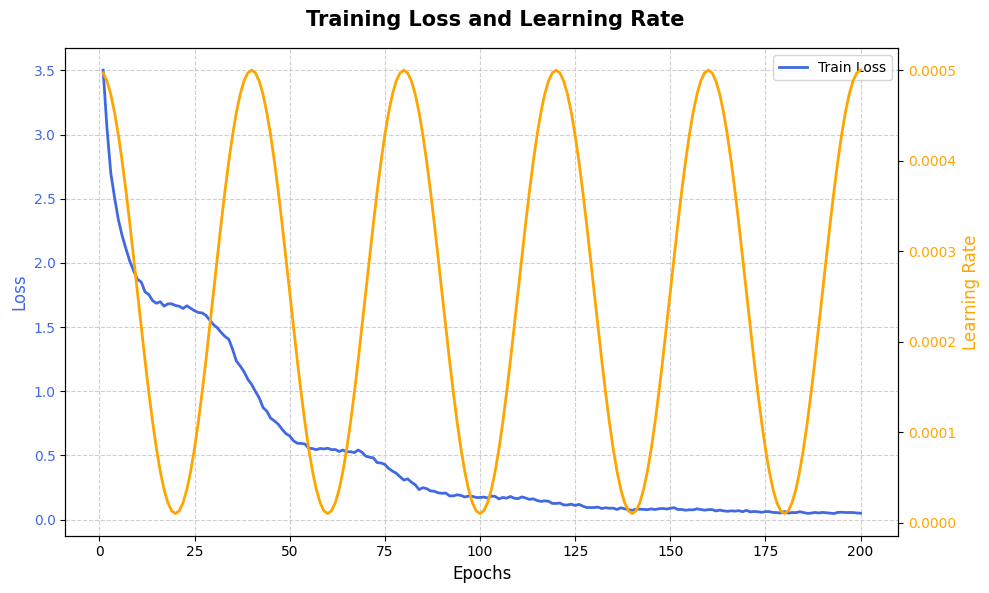

In [30]:
# Ensure data is aligned
epochs = list(range(1, len(train_losses)+1))
fig , ax1 = plt.subplots(figsize=(10,6), dpi=100)

# Train Loss
plt.plot(epochs, train_losses, color='royalblue', linewidth=2, label="Train Loss")
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylabel("Loss", color = 'royalblue', fontsize = 12)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.legend(loc='best')

# Learning Rate
ax2 = ax1.twinx()
ax2.plot(epochs, lr_history, color='orange', linewidth=2, label="Learning Rate")
ax2.set_ylabel("Learning Rate", color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle("Training Loss and Learning Rate", fontsize=15, fontweight='bold')
fig.tight_layout()
plt.show()

# <a id="Import"></a><p style="background: linear-gradient(to right, #1b5e20, #2e7d32, #388e3c, #43a047, #4caf50); font-family: 'Times New Roman', serif; font-size: 28px; font-weight: bold; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2); -webkit-background-clip: text; -webkit-text-fill-color: transparent;">Thanks & Upvote ❤️</p>